Tuning hyperparameters with grid search
---

In [1]:
import pandas as pd

# Load the data
data_df = pd.read_csv('house-prices.csv')
data_df.head()

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,484,528275070,60,RL,NaN,8795,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,4,2009,WD,Normal,236000
1,2586,535305120,20,RL,75.0,10170,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,6,2006,WD,Normal,155000
2,2289,923228250,160,RM,21.0,2001,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,1,2007,WD,Normal,75000
3,142,535152150,20,RL,70.0,10552,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,165500
4,2042,903475060,190,RM,60.0,10120,Pave,NaN,IR1,Bnk,...,0,NaN,MnPrv,NaN,0,1,2007,WD,Normal,122000


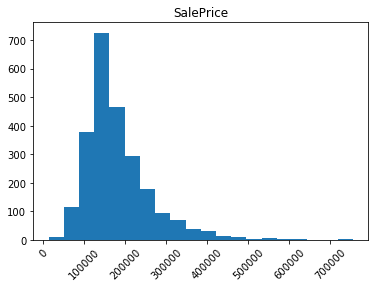

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

data_df.hist(column='SalePrice', bins=20, grid=False, xrot=45)
plt.show()

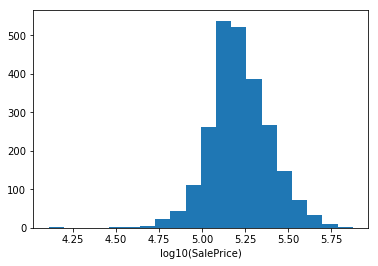

In [3]:
import numpy as np

plt.hist(np.log10(data_df.SalePrice), bins=20)
plt.xlabel('log10(SalePrice)')
plt.show()

In [8]:
def preprocess(df):
    # Work on a copy
    df = df.copy()
    
    # One-hot encoding
    df = pd.get_dummies(df, dummy_na=True)
    
    # Fill missing values
    for c in df.columns:
        df[c] = df[c].fillna(df[c].median())
        
    return df

preprocessed_df = preprocess(data_df)
preprocessed_df.head()


,Order,PID,MS SubClass,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,...,Sale Type_VWD,Sale Type_WD,Sale Type_nan,Sale Condition_Abnorml,Sale Condition_AdjLand,Sale Condition_Alloca,Sale Condition_Family,Sale Condition_Normal,Sale Condition_Partial,Sale Condition_nan
0,484,528275070,60,68.0,8795,7,5,2000,2000,0.0,...,0,1,0,0,0,0,0,1,0,0
1,2586,535305120,20,75.0,10170,6,6,1951,1951,522.0,...,0,1,0,0,0,0,0,1,0,0
2,2289,923228250,160,21.0,2001,4,5,1970,1970,80.0,...,0,1,0,0,0,0,0,1,0,0
3,142,535152150,20,70.0,10552,5,5,1959,1959,0.0,...,0,1,0,0,0,0,0,1,0,0
4,2042,903475060,190,60.0,10120,7,4,1910,1950,0.0,...,0,1,0,0,0,0,0,1,0,0


In [9]:
from sklearn.model_selection import train_test_split

# Create X, y
X = preprocessed_df.drop('SalePrice', axis=1).values
y = np.log10(preprocessed_df.SalePrice).values

# Split into train/test sets
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.5, random_state=0)

print('Train:', X_tr.shape, y_tr.shape)
print('Test:', X_te.shape, y_te.shape)

Train: (1215, 347) (1215,)
Test: (1215, 347) (1215,)


In [10]:
from sklearn.preprocessing import StandardScaler

# Standardize features
scaler = StandardScaler()
X_tr_rescaled = scaler.fit_transform(X_tr)
X_te_rescaled = scaler.transform(X_te)

In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as MSE

# Try with a linear regression
lr = LinearRegression()
lr.fit(X_tr_rescaled, y_tr)

print('Train MSE: {:.4f}'.format(MSE(y_tr, lr.predict(X_tr_rescaled))))
print('Test MSE: {:.4f}'.format(MSE(y_te, lr.predict(X_te_rescaled))))

Train MSE: 0.0014
Test MSE: 56439750850494968365056.0000


In [12]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error as MAE

# Variable to store the results
gs_results = []

# Grid search
for alpha in np.logspace(-10, 10, num=100):
    # Create and fit ridge regression
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_tr_rescaled, y_tr)
    
    # Save model and its performance on train/test sets
    gs_results.append({
        'alpha': alpha,
        'train_mse': MSE(y_tr, ridge.predict(X_tr_rescaled)),
        'train_mae': MAE(10**y_tr, 10**ridge.predict(X_tr_rescaled)),
        'test_mse': MSE(y_te, ridge.predict(X_te_rescaled)),
        'test_mae': MAE(10**y_te, 10**ridge.predict(X_te_rescaled)),
    })

# Convert results to DataFrame
gs_results = pd.DataFrame(gs_results)
gs_results.head()

,alpha,test_mae,test_mse,train_mae,train_mse
0,1.000000e-10,17816.512480,0.006008,11145.427596,0.001412
1,1.592283e-10,17815.840526,0.006007,11145.427596,0.001412
2,2.535364e-10,17817.701336,0.006008,11145.427596,0.001412
3,4.037017e-10,17816.995786,0.006007,11145.427596,0.001412
4,6.428073e-10,17816.953261,0.006007,11145.427596,0.001412


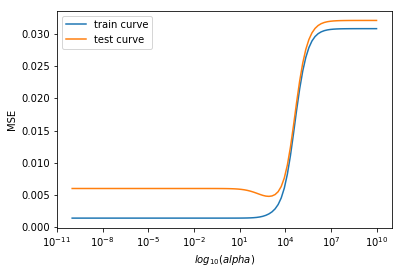

In [13]:
# Plot the validation curves
plt.semilogx(gs_results['alpha'], gs_results['train_mse'], label='train curve')
plt.semilogx(gs_results['alpha'], gs_results['test_mse'], label='test curve')
plt.xlabel('$log_{10}(alpha)$')
plt.ylabel('MSE')
plt.legend()
plt.show()

In [14]:
# Fit a model with a very strong regularization
strong_ridge = Ridge(alpha=10**10)
strong_ridge.fit(X_tr_rescaled, y_tr)

print('Largest coefficient: {:.1e}'.format(
    np.max(np.abs(strong_ridge.coef_))))
print('Intercept: {:.2f}'.format(
    strong_ridge.intercept_))

Largest coefficient: 1.8e-08
Intercept: 5.23


In [15]:
print('Mean target value: {:.2f}'.format(np.mean(y_tr)))

Mean target value: 5.23


In [16]:
# Get entry with the best test MSE
best_result = gs_results.loc[gs_results.test_mse.idxmin()]

# Print the details
print('Best alpha: {:.1e}'.format(best_result.alpha))
print('Test MSE: {:.4f}'.format(best_result.test_mse))
print('Test MAE: {:,.0f}$'.format(best_result.test_mae))

Best alpha: 8.5e+02
Test MSE: 0.0048
Test MAE: 15,671$


In [17]:
# Fit/test N models
gs_results = []
for run_idx in range(10):
    # Split into train/test sets
    X_tr, X_te, y_tr, y_te = train_test_split(
        X, y, test_size=0.5, random_state=run_idx)
    
    # Standardize features
    X_tr_rescaled = scaler.fit_transform(X_tr)
    X_te_rescaled = scaler.transform(X_te)

    # Grid search
    for alpha in np.logspace(1, 4, num=20):
        # Create and fit ridge regression
        ridge = Ridge(alpha=alpha)
        ridge.fit(X_tr_rescaled, y_tr)

        # Save model and its performance on train/test sets
        gs_results.append({
            'alpha': alpha,
            'run_idx': run_idx,
            'train_mse': MSE(y_tr, ridge.predict(X_tr_rescaled)),
            'train_mae': MAE(10**y_tr, 10**ridge.predict(X_tr_rescaled)),
            'test_mse': MSE(y_te, ridge.predict(X_te_rescaled)),
            'test_mae': MAE(10**y_te, 10**ridge.predict(X_te_rescaled)),
        })
        
# Convert results to DataFrame
gs_results = pd.DataFrame(gs_results)
gs_results.head()

,alpha,run_idx,test_mae,test_mse,train_mae,train_mse
0,10.000000,0,17485.758076,0.005898,11151.125598,0.001416
1,14.384499,0,17372.165040,0.005857,11161.657456,0.001419
2,20.691381,0,17233.571836,0.005802,11176.962177,0.001424
3,29.763514,0,17067.620448,0.005733,11198.863815,0.001431
4,42.813324,0,16871.527796,0.005647,11233.772529,0.001442


In [18]:
# Group results by alpha value
gb_alpha = gs_results.groupby('alpha')

# Compute train/test mean scores with std
mean_tr = gb_alpha.train_mse.mean()
mean_te = gb_alpha.test_mse.mean()
std_tr = gb_alpha.train_mse.std()
std_te = gb_alpha.test_mse.std()
alphas = mean_tr.index.values

# Get entry with the best mean test MSE
best_alpha = mean_te.idxmin()
best_result = gb_alpha.get_group(best_alpha)

# Print the details
print('Best alpha: {:.1e}'.format(best_alpha))
print('Test MSE: {:.4f}'.format(best_result.test_mse.mean()))
print('Test MAE: {:,.0f}$'.format(best_result.test_mae.mean()))

Best alpha: 5.5e+02
Test MSE: 0.0038
Test MAE: 15,700$


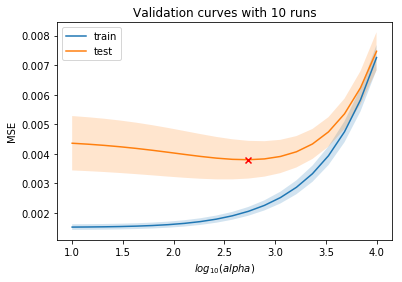

In [19]:
# Plot mean scores
plt.plot(np.log10(alphas), mean_tr, label='train')
plt.plot(np.log10(alphas), mean_te, label='test')

# Quantify variance with ±std curves
plt.fill_between(np.log10(alphas), mean_tr-std_tr, mean_tr+std_tr, alpha=0.2)
plt.fill_between(np.log10(alphas), mean_te-std_te, mean_te+std_te, alpha=0.2)

# Add marker for best score
plt.scatter(np.log10(best_alpha), mean_te.min(), marker='x', c='red', zorder=10)

plt.title('Validation curves with {} runs'.format(len(gs_results.groupby('run_idx'))))
plt.xlabel('$log_{10}(alpha)$')
plt.ylabel('MSE')
plt.legend()
plt.show()